In [ ]:
# Librerias.

import pandas as pd
import json
from shapely.geometry import Point, Polygon
import numpy as np
import pyproj
import csv
from statsmodels.tsa.stattools import adfuller 
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from tqdm import tqdm

Con los csv de las coordenadas de los caladeros y de los valores de clorofila, obtenemos los valores de clorofila para cada caladero.

In [ ]:
# Función para cargar el GeoJSON desde un archivo.
def cargar_geojson(ruta):
    with open(ruta, "r") as archivo:
        geojson_data = json.load(archivo)
    return geojson_data

# Función para extraer las coordenadas de los polígonos.
def obtener_coordenadas_poligonos(geojson_data):
    coordenadas_poligonos = []
    for feature in geojson_data["features"]:
        # Verificar si la geometría es un polígono.
        if feature["geometry"]["type"] == "Polygon":
            coordenadas_poligono = feature["geometry"]["coordinates"][0]  # Primer conjunto de coordenadas.
            coordenadas_poligonos.append(coordenadas_poligono)
    return coordenadas_poligonos

# Ruta al archivo GeoJSON.
ruta_geojson = r"ruta a caladeros.geojson"

# Cargar el GeoJSON desde el archivo.
geojson_data = cargar_geojson(ruta_geojson)

# Obtener las coordenadas de los polígonos.
coordenadas_poligonos = obtener_coordenadas_poligonos(geojson_data)

# Imprimir las coordenadas de cada polígono.
for i, poligono in enumerate(coordenadas_poligonos, start=1):
    print(f"Polígono {i}:")
    for coordenada in poligono:
        print(coordenada)


In [ ]:
# Convertir las coordenadas de los polígonos a objetos Polygon.
poligonos = [Polygon(poligono) for poligono in coordenadas_poligonos]

# Función para convertir coordenadas latitud y longitud a UTM.
def lat_lon_a_utm(coordenadas_lat_lon):
    proj_lat_lon = pyproj.Proj(proj='latlong', ellps='WGS84')
    proj_utm = pyproj.Proj(proj='utm', zone=30, ellps='WGS84') 
    utm_coords = [pyproj.transform(proj_lat_lon, proj_utm, lon, lat) for lon, lat in coordenadas_lat_lon]
    return utm_coords

# Función para generar coordenadas aleatorias dentro del área del polígono.
def generar_coordenadas_dentro(poligono, rango_x, rango_y, num_puntos):
    x_vals = np.random.uniform(rango_x[0], rango_x[1], num_puntos)
    y_vals = np.random.uniform(rango_y[0], rango_y[1], num_puntos)
    coordenadas = [(x, y) for x, y in zip(x_vals, y_vals)]
    puntos_dentro = [punto for punto in coordenadas if poligono.contains(Point(punto))]
    return puntos_dentro

# Función para convertir coordenadas UTM a latitud y longitud.
def utm_a_lat_lon(coordenadas_utm):
    proj_utm = pyproj.Proj(proj='utm', zone=30, ellps='WGS84') 
    proj_lat_lon = pyproj.Proj(proj='latlong', ellps='WGS84')
    lat_lon = [pyproj.transform(proj_utm, proj_lat_lon, x, y) for x, y in coordenadas_utm]
    return lat_lon

# Definir el rango de coordenadas para generar puntos aleatorios en latitud y longitud.
rango_latitud = (36, 37)  
rango_longitud = (-6, -1) 

# Convertir el rango de latitud y longitud a UTM.
rango_lat_lon = [(rango_longitud[0], rango_latitud[0]), (rango_longitud[1], rango_latitud[1])]
rango_utm = lat_lon_a_utm(rango_lat_lon)

# Definir el rango de coordenadas para generar puntos aleatorios en UTM.
rango_x = (rango_utm[0][0], rango_utm[1][0])
rango_y = (rango_utm[0][1], rango_utm[1][1])

# Número de puntos aleatorios a generar en cada ciclo.
num_puntos = 1000

# Inicializar un diccionario para almacenar los puntos por polígono.
puntos_por_poligono = {i: [] for i in range(1, len(poligonos) + 1)}

# Realizar el bucle para generar puntos múltiples veces.
for _ in range(100):
    # Generar puntos aleatorios dentro de cada polígono en el rango especificado.
    for idx, poligono in enumerate(poligonos, start=1):
        puntos_dentro = generar_coordenadas_dentro(poligono, rango_x, rango_y, num_puntos)
        if puntos_dentro:
            puntos_por_poligono[idx].extend(puntos_dentro)

# Guardar los puntos en un archivo CSV.
with open('puntos_dentro_de_caladero.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Polígono', 'Punto', 'Latitud', 'Longitud'])
    for poligono, puntos in puntos_por_poligono.items():
        for idx, punto in enumerate(puntos, start=1):
            utm_coords = [(punto[0], punto[1])]
            lat_lon = utm_a_lat_lon(utm_coords)[0]
            writer.writerow([poligono, idx, lat_lon[0], lat_lon[1]])

# Imprimir el número total de puntos por polígono.
for poligono, puntos in puntos_por_poligono.items():
    print("Número de puntos dentro del Polígono", poligono, ":", len(puntos))


Ahora, se renombran los poligonos de 1 a n según su aparición.

In [2]:
def renumerar_poligonos_y_limitar_decimales(archivo_entrada, archivo_salida):
    # Diccionario para hacer el mapeo entre los polígonos actuales y los nuevos.
    mapeo_poligonos = {}
    nuevo_numero_poligono = 1

    with open(archivo_entrada, 'r') as csv_entrada:
        lector_csv = csv.DictReader(csv_entrada)
        with open(archivo_salida, 'w', newline='') as csv_salida:
            # Escribir la nueva cabecera
            escritor_csv = csv.DictWriter(csv_salida, fieldnames=lector_csv.fieldnames)
            escritor_csv.writeheader()

            for fila in lector_csv:
                poligono_actual = int(fila['Polígono'])
                # Si el polígono actual no está en el mapeo, asignarle un nuevo número.
                if poligono_actual not in mapeo_poligonos:
                    mapeo_poligonos[poligono_actual] = nuevo_numero_poligono
                    nuevo_numero_poligono += 1
                
                # Actualizar el número de polígono en la fila.
                fila['Polígono'] = mapeo_poligonos[poligono_actual]

                # Limitar la cantidad de decimales en latitud y longitud a 4.
                fila['Latitud'] = "{:.4f}".format(float(fila['Latitud']))
                fila['Longitud'] = "{:.4f}".format(float(fila['Longitud']))
                
                # Escribir la fila actualizada en el archivo de salida.
                escritor_csv.writerow(fila)
                

archivo_entrada = 'puntos_dentro_de_caladero.csv'
archivo_salida = 'coordenadas_caladeros.csv'
renumerar_poligonos_y_limitar_decimales(archivo_entrada, archivo_salida)

Con los puntos de coordenadas dentro de cada caladero delimitados, procedemos a obtener los valores de clorofila dentro de dichos caladeros.

In [20]:
# Cargar los datos de los archivos CSV
df_coordenadas = pd.read_csv("ruta a coordenadas_caladeros.csv", usecols=['Caladero', 'Latitud', 'Longitud'], encoding="latin1")
df_clorofila = pd.read_csv(" ruta a clorofila.csv")

# Eliminar filas con valores nulos o no válidos en Chl_a.
df_clorofila = df_clorofila[df_clorofila['Chl_a'] != '--']
df_clorofila['Chl_a'] = df_clorofila['Chl_a'].astype(float)

# Crear un nuevo DataFrame para almacenar los resultados.
df_resultado = pd.DataFrame(columns=['Año', 'Mes', 'Caladero', 'Clorofila'])

# Iterar sobre cada combinación de año, mes y caladero para calcular el valor medio de clorofila.
for año in df_clorofila['Año'].unique():
    for mes in df_clorofila['MesID'].unique():
        for caladero in df_coordenadas['Caladero'].unique():
            # Filtrar las coordenadas de clorofila para el año, mes y caladero.
            clorofila_mes_caladero = df_clorofila[(df_clorofila['Año'] == año) & (df_clorofila['MesID'] == mes)]
            # Filtrar las coordenadas del caladero.
            coordenadas_caladero = df_coordenadas[df_coordenadas['Caladero'] == caladero]
            
            # Calcular el promedio de clorofila para ese caladero, año y mes.
            suma_clorofila = 0
            num_coordenadas = 0
            for _, coord in coordenadas_caladero.iterrows():
                latitud_2_digitos = str(coord['Latitud'])[:2]
                longitud_2_digitos = str(coord['Longitud'])[:2]
                if (latitud_2_digitos, longitud_2_digitos) in zip(clorofila_mes_caladero['Latitud'].astype(str).str[:2], clorofila_mes_caladero['Longitud'].astype(str).str[:2]):
                    clorofila = clorofila_mes_caladero[
                        (clorofila_mes_caladero['Latitud'].astype(str).str[:2] == latitud_2_digitos) & 
                        (clorofila_mes_caladero['Longitud'].astype(str).str[:2] == longitud_2_digitos)
                    ]['Chl_a'].values[0]
                    suma_clorofila += clorofila
                    num_coordenadas += 1
            
            promedio_clorofila = suma_clorofila / num_coordenadas if num_coordenadas > 0 else 0
            
            # Agregar el resultado al DataFrame.
            df_resultado = pd.concat([df_resultado, pd.DataFrame({'Año': año, 'Mes': mes, 'Caladero': caladero, 'Clorofila': [promedio_clorofila]})], ignore_index=True)

# Guardar el DataFrame resultante.
df_resultado.to_csv("resultado_clorofila_caladeros.csv", index=False)


Debido a que los datos disponibles de clorofila no cubren toda la serie temporal deseada, realzaremos una reparación de los valores de la serie teporal mediante la prueba de Dickey-Fuller para determinar la estacianoriedad de la serie y la reparación de los valores mediante el método ARIMA.

In [20]:
# Cargar los datos.
df = pd.read_csv('ruta a clorofila_caladeros.csv')

# Verificar la estacionariedad de la serie temporal.
result = adfuller(df['Media_Clorofila'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])




ADF Statistic: -4.1079701189140305
p-value: 0.0009395584374905386


Error cuadrático medio (MSE) del modelo de bosque aleatorio: 0.021880362406954724


Años:   0%|          | 0/25 [00:00<?, ?it/s]
c:\Users\pejer\Desktop\BOOTCAMP\entorno\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\pejer\AppData\Local\Temp\ipykernel_15060\66577118.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados_prediccion = pd.concat([resultados_prediccion, temp_df], ignore_index=True)
c:\Users\pejer\Desktop\BOOTCAMP\entorno\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\pejer\Desktop\BOOTCAMP\entorno\lib\site-packages\sklearn\base.py:493: UserWarning: X does not

Resultados de la predicción guardados en 'resultados_prediccion_clorofila.csv'


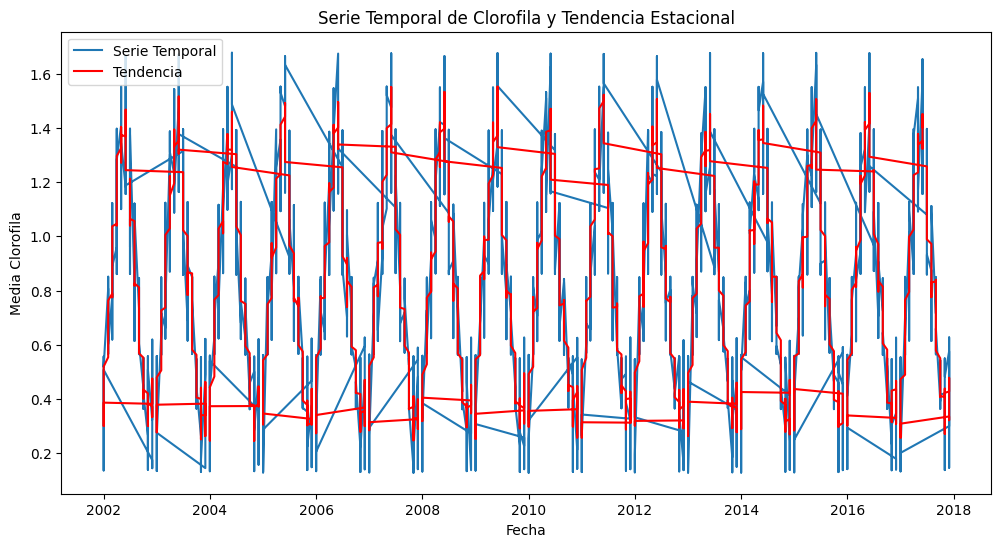

In [23]:
# Cargar el conjunto de datos.
df = pd.read_csv('ruta a clorofila_caladeros.csv')

# Descomponer la serie temporal para obtener la tendencia estacional.
df['Fecha'] = pd.to_datetime(df['Año'].astype(str) + '-' + df['Mes'].astype(str), format='%Y-%m')
df.set_index('Fecha', inplace=True)
decomposition = seasonal_decompose(df['Media_Clorofila'], model='additive', period=12)
trend = decomposition.trend

# Entrenar el modelo.
X = df[['Año', 'Mes', 'Caladero']]
y = df['Media_Clorofila']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicción.
y_pred = model.predict(X_test)

# Evaluación del modelo.
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio (MSE) del modelo de bosque aleatorio:", mse)

# Generar DataFrame final para la predicción.
# Definir los años, meses y caladeros para la predicción.
años_deseados = range(2000, 2025)
meses_deseados = range(1, 13)
caladeros_deseados = range(1, 85)

# Crear un DataFrame vacío para almacenar los resultados de la predicción.
resultados_prediccion = pd.DataFrame(columns=['Año', 'Mes', 'Caladero', 'Media_Clorofila'])

# Iterar sobre cada combinación de año, mes y caladero para predecir la Media_Clorofila.
for año in tqdm(años_deseados, desc="Años"):
    for mes in tqdm(meses_deseados, desc="Meses", leave=False):
        for caladero in tqdm(caladeros_deseados, desc="Caladeros", leave=False):
            # Predecir el valor de Media_Clorofila para la combinación actual.
            valor_predicho = model.predict([[año, mes, caladero]])
            # Almacenar el resultado en un DataFrame temporal.
            temp_df = pd.DataFrame({'Año': [año], 'Mes': [mes], 'Caladero': [caladero], 'Media_Clorofila': [valor_predicho[0]]})
            # Concatenar el DataFrame temporal al DataFrame principal.
            resultados_prediccion = pd.concat([resultados_prediccion, temp_df], ignore_index=True)
            
# Guardar los resultados de la predicción en un archivo CSV.
resultados_prediccion.to_csv('resultados_prediccion_clorofila.csv', index=False)

# Visualización de la serie temporal y la tendencia.
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Media_Clorofila'], label='Serie Temporal')
plt.plot(trend.index, trend, label='Tendencia', color='red')
plt.title('Serie Temporal de Clorofila y Tendencia Estacional')
plt.xlabel('Fecha')
plt.ylabel('Media Clorofila')
plt.legend()
plt.show()


Ahora con la serie temporal completa, integramos el pH en el DataFrame.

In [28]:
# Cargar los datos de resultados_prediccion_clorofila.csv.
df_clorofila = pd.read_csv('ruta a resultados_prediccion_clorofila.csv')

# Definir el diccionario de mapeo con los valores de pH correspondientes a cada año.
mapeo_pH = {
    2024: 8.072,
    2023: 8.070,
    2022: 8.066,
    2021: 8.073,
    2020: 8.070,
    2019: 8.069,
    2018: 8.073,
    2017: 8.072,
    2016: 8.076,
    2015: 8.073,
    2014: 8.080,
    2013: 8.081,
    2012: 8.085,
    2011: 8.082,
    2010: 8.083,
    2009: 8.087,
    2008: 8.090,
    2007: 8.089,
    2006: 8.091,
    2005: 8.091,
    2004: 8.095,
    2003: 8.092,
    2002: 8.094,
    2001: 8.095,
    2000: 8.092
}

# Mapear los valores de pH según el año en el DataFrame.
df_clorofila['pH'] = df_clorofila['Año'].map(mapeo_pH)

# Guardar el resultado en un nuevo archivo CSV.
df_clorofila.to_csv('resultados_prediccion_clorofila_con_pH.csv', index=False)


